# Sentiment Analysis Using Text - for Social Media feedback and profiel analysis

In [ ]:
!pip install --quiet kaggle
!pip install --quiet python-dotenv


## 1. Importing Libraries and Setting Up

This block handles the import of necessary libraries and setting up the environment. It includes libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), natural language processing (NLTK), machine learning (Scikit-learn, TensorFlow), and handling environment variables (dotenv). The script sets up styling for plots, suppresses warnings, and configures environment variables for accessing Kaggle's API.



In [13]:
from google.colab import drive
import dotenv
import os

In [14]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, roc_curve, auc
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from mlxtend.plotting import plot_confusion_matrix
import dotenv
import os

In [15]:


# Styling and warnings
plt.style.use('ggplot')
nltk.download(['stopwords', 'wordnet'])
warnings.filterwarnings("ignore")

# Loading environment variables for Kaggle API
dotenv.load_dotenv('/content/drive/MyDrive/Teaching/TME_6015/Credentials/.env')

_kaggle_username="sjunbca"
_kaggle_key="a9d22a14ff656b11495b582ca6989c85"



os.environ['KAGGLE_USERNAME'] = _kaggle_username
os.environ['KAGGLE_KEY'] = _kaggle_key


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Downloading and Preparing Dataset

This block downloads the Sentiment140 dataset from Kaggle, unzips it, and loads it into a Pandas DataFrame. The data is then sampled and column names are assigned.**bold text**


In [16]:

# Downloading and extracting dataset
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [17]:
# Loading the dataset
def load_data(file_path, encodings):
    for encoding in encodings:
        try:
            data = pd.read_csv(file_path, encoding=encoding)
            print(f"Data loaded successfully with encoding: {encoding}")
            return data
        except UnicodeDecodeError as e:
            print(f"Error with encoding: {encoding} - {e}")

## 3. Data Preprocessing

This section focuses on cleaning and preprocessing the text data. It involves selecting relevant columns, cleaning tweets (removing URLs, mentions, punctuation, and repetitive characters), removing stopwords, and applying stemming and lemmatization to the text.

In [18]:
# Loading the dataset
def load_data(file_path, encodings):
    for encoding in encodings:
        try:
            data = pd.read_csv(file_path, encoding=encoding)
            print(f"Data loaded successfully with encoding: {encoding}")
            return data
        except UnicodeDecodeError as e:
            print(f"Error with encoding: {encoding} - {e}")

Data loaded successfully with encoding: ISO-8859-1


In [19]:
# Preprocessing the data
tweets_df = tweets_df[['tweet', 'sentiment']]
tweets_df['sentiment'] = tweets_df['sentiment'].replace(4, 1)

In [20]:
# Function to clean tweets
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub('@[^\s]+', ' ', tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ', tweet)
    tweet = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    return tweet


In [21]:
tweets_df['tweet'] = tweets_df['tweet'].apply(clean_tweet)

# Removing stopwords
stop_words = set(stopwords.words('english'))
tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [22]:
# Stemming and Lemmatization
stemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()

def stem_and_lemmatize(tweet):
    words = tweet.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return ' '.join(lemmatized_words)

tweets_df['tweet'] = tweets_df['tweet'].apply(stem_and_lemmatize)

## 4. Preparing Data for Model Training

This block prepares the dataset for training the model. It tokenizes the tweets, converts them into sequences, and pads these sequences to a fixed length. The dataset is then split into training and testing sets.


In [23]:
# Preparing the data for model training
X = tweets_df['tweet']
y = tweets_df['sentiment']

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=500)

In [24]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.3, random_state=42)

## 5. Building and Training the Model
In this block, a sentiment analysis model is built using Keras. The model consists of an embedding layer, an LSTM layer, a dense layer, and a dropout layer. The model is compiled and trained on the training data.


In [25]:
# Building the model
def build_model():
    input_layer = Input(shape=[500], name='input')
    embedding_layer = Embedding(2000, 50, input_length=500)(input_layer)
    lstm_layer = LSTM(64)(embedding_layer)
    dense_layer = Dense(256, activation='relu')(lstm_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

sentiment_model = build_model()
sentiment_model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [26]:
# Training the model
history = sentiment_model.fit(X_train, y_train, batch_size=80, epochs=6, validation_split=0.1)

Epoch 1/6
1260/1260 [==============================] - 307s 242ms/step - loss: 0.5302 - accuracy: 0.7326 - val_loss: 0.5021 - val_accuracy: 0.7560
Epoch 2/6
1260/1260 [==============================] - 304s 241ms/step - loss: 0.4913 - accuracy: 0.7641 - val_loss: 0.4979 - val_accuracy: 0.7622
Epoch 3/6
1260/1260 [==============================] - 302s 240ms/step - loss: 0.4812 - accuracy: 0.7706 - val_loss: 0.4942 - val_accuracy: 0.7634
Epoch 4/6
1260/1260 [==============================] - 301s 239ms/step - loss: 0.4738 - accuracy: 0.7746 - val_loss: 0.4923 - val_accuracy: 0.7656
Epoch 5/6
1260/1260 [==============================] - 302s 240ms/step - loss: 0.4682 - accuracy: 0.7774 - val_loss: 0.4907 - val_accuracy: 0.7636
Epoch 6/6
1260/1260 [==============================] - 303s 240ms/step - loss: 0.4629 - accuracy: 0.7811 - val_loss: 0.4908 - val_accuracy: 0.7629


## 6.Evaluating the Model
The final block of the script evaluates the performance of the trained model on the test dataset. It prints the test accuracy, generates a confusion matrix, and plots it. Additionally, it plots the Receiver Operating Characteristic (ROC) curve to assess the model's performance in distinguishing between classes.

In [27]:
# Evaluating the model
test_acc = sentiment_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc[1]:.2f}')

1500/1500 [==============================] - 62s 41ms/step - loss: 0.4859 - accuracy: 0.7663
Test Accuracy: 0.77


In [28]:
# Generating predictions and confusion matrix
predictions = sentiment_model.predict(X_test)
predictions = (predictions > 0.5)
conf_matrix = confusion_matrix(y_test, predictions)

1500/1500 [==============================] - 62s 41ms/step


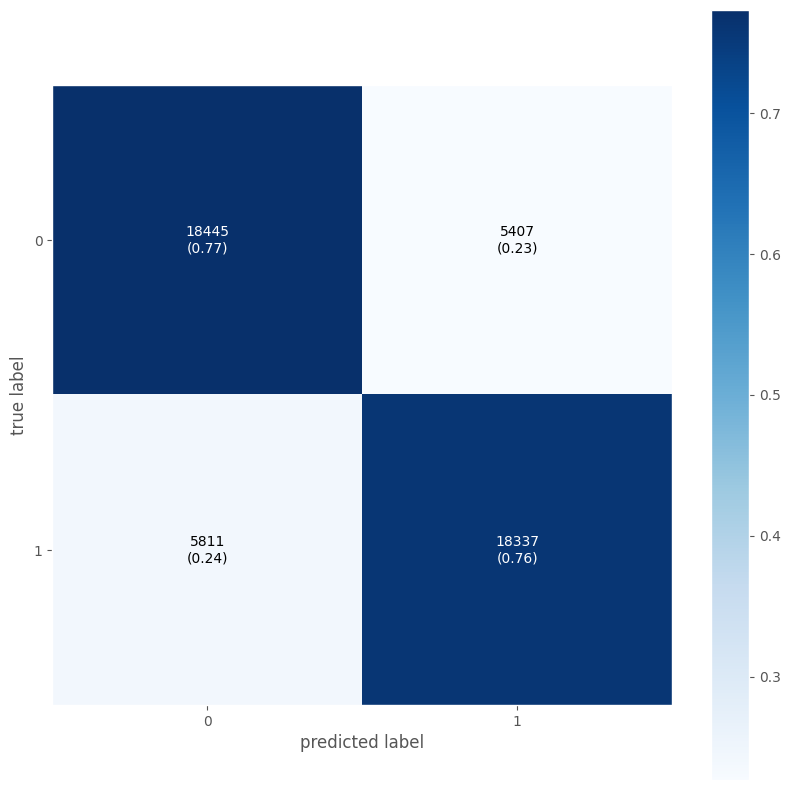

In [29]:
# Plotting confusion matrix
plot_confusion_matrix(conf_mat=conf_matrix, figsize=(10, 10), show_absolute=True, show_normed=True, colorbar=True)
plt.show()

## Observations based on the matrix:

The model has a high number of true positives/negatives (correct predictions), as indicated by the larger numbers in the diagonal cells. For class '0', there are 18,445 correct predictions, and for class '1', there are 18,337 correct predictions.

The model has made a significant number of false predictions as well, although they are less than the true predictions. For class '0', it incorrectly predicted 5,407 instances as class '1', and for class '1', it incorrectly predicted 5,811 instances as class '0'.

The ratios in the parentheses indicate the proportion of total predictions that were correct for each class. For class '0', about 77% of the predictions were correct, and for class '1', about 76% of the predictions were correct.

The color intensity suggests that the model is relatively balanced in terms of prediction accuracy across both classes, which is good for a binary classifier. There is not a strong bias towards one class.

To further assess the model's performance, you'd typically consider metrics such as accuracy, precision, recall, and F1 score. These are not provided in the confusion matrix but can be calculated based on the numbers given.

Overall, the model seems to be performing reasonably well, with a balanced accuracy across the two classes. However, there is still a notable number of false predictions, which suggests that there might be room for improvement, possibly by further training, parameter tuning, or using a different model architecture.

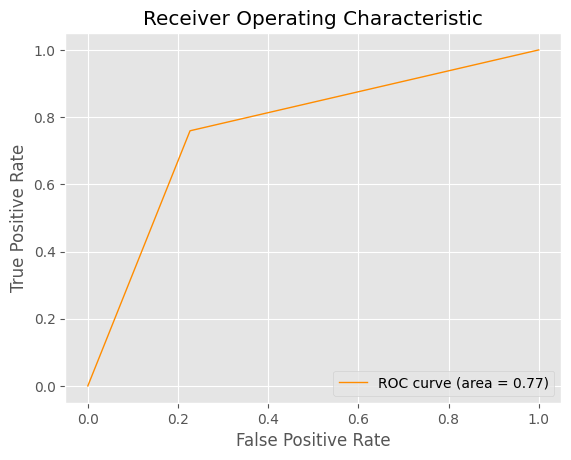

In [30]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## observations based on the ROC curve:

Area Under the Curve (AUC): The ROC curve has an area of 0.77, as indicated in the legend. An AUC of 1 represents a perfect model, while an AUC of 0.5 represents a model with no discriminative ability, equivalent to random guessing. With an AUC of 0.77, the model has good discriminative ability, although there is still room for improvement.

Performance at Various Thresholds: The shape of the curve suggests that the model performs significantly better than random chance across all thresholds. The curve rises quickly towards the top-left corner, which indicates a high true positive rate for a low false positive rate, which is desirable in a classifier.

Optimal Threshold: The 'elbow' of the ROC curve represents an optimal balance between sensitivity (TPR) and specificity (1 - FPR). The model's threshold set at this point would offer a beneficial trade-off between detecting positive cases and avoiding false alarms. In this curve, the elbow isn't sharply defined, which may suggest that the optimal threshold could be a range rather than a specific value.

Performance Inference: The fact that the ROC curve stays well above the diagonal line (which would represent random guessing) throughout suggests the model has learned patterns from the data and is making informed predictions rather than guessing.

Comparison with Other Models: If comparing multiple models, one would look for a ROC curve that stays closer to the top-left corner of the plot. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.

Potential Bias: If the curve was closer to the diagonal or below it at any point, it would suggest potential bias or problems with the model. However, this does not seem to be the case with your model.

In summary, the ROC curve for your sentiment analysis model indicates that it has good predictive power, with an AUC of 0.77. This suggests the model is able to distinguish between the classes (likely positive and negative sentiment) better than chance, but still has potential for improvement.

# Implementing the model with custom feedback reviews for Event Feedbacks




In [32]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# '/content/drive/MyDrive/Teaching/TME_6015/Final_Project/sentiment_text/one/comments.csv'

In [36]:
from google.colab import drive
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Mount Google Drive
drive.mount('/content/drive')

# Load the new CSV file without headers
file_path = '/content/drive/MyDrive/Teaching/TME_6015/Final_Project/sentiment_text/one/comments.csv'  # Replace with your file path
new_data = pd.read_csv(file_path, header=None)
new_data.columns = ['tweet']  # Assigning the column name

# Preprocess the new data (reuse your `clean_tweet` and `stem_and_lemmatize` functions)
new_data['tweet'] = new_data['tweet'].apply(clean_tweet)
new_data['tweet'] = new_data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
new_data['tweet'] = new_data['tweet'].apply(stem_and_lemmatize)

# Tokenize and pad the new data
new_seq = tokenizer.texts_to_sequences(new_data['tweet'])
new_pad = pad_sequences(new_seq, maxlen=500)

# Predict sentiments
new_predictions = sentiment_model.predict(new_pad)
new_predictions = (new_predictions > 0.5).astype(int)

# Convert numeric predictions to textual labels
sentiment_labels = {0: 'Negative', 1: 'Positive'}
new_data['predicted_sentiment'] = new_predictions
new_data['predicted_sentiment'] = new_data['predicted_sentiment'].map(sentiment_labels)


# Save or display the results
output_path = '/content/drive/MyDrive/Teaching/TME_6015/Final_Project/sentiment_text/one/path_to_output_file.csv'  # Replace with your desired output path
new_data.to_csv(output_path, index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
6/6 [==============================] - 1s 88ms/step


In [38]:
new_data.head()


,tweet,predicted_sentiment
0,absolut love event 🎉 everyth topnotch bestdayev,Positive
1,great experi confer learn lot thank 😊 educ,Positive
2,fantast perform last night bravo al artist 👏 c...,Positive
3,workshop incred insight inspir learningjourney,Positive
4,love diver energi festiv wil return next year ...,Positive
